In [1]:
import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
%matplotlib inline

In [49]:
P1 = "/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.pinatubotest/atm/hist/"
P2 = "/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/atm/hist/"
P3 = "/projects/0/nwo2021025/cesm1_0_4/spinup_pd_maxcores_f09_g16/output/cam/hist/"
P4 = "/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/output/cam/hist/"
P5 = "/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/output/atm/hist"

In [41]:
def read_netcdfs(files, dim, data_vars=None):
    """read unprocessed CESM model output"""
    def open_file(path):
        with xr.open_dataset(path) as ds:
            if data_vars is not None:
                ds = ds[data_vars]
            ds.load()
            return ds
    
    if isinstance(files,list):
        paths = sorted(files)
    else:
        paths = sorted(glob.glob(files))
    datasets = [open_file(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined


def weighted_tmean(ds): 
    td = ds.time_bnds.diff('nbnd').squeeze('nbnd').astype('float')
    return ds.weighted(td).mean('time')

### 1 deg resolution

In [51]:
files = glob.glob(os.path.join(P4+"/spinup_pd_maxcores_f09_g16.cam2.h0.????-??.nc"))
files_lr_190_210 = sorted([f for f in files if int(f[-9:-6]) in range(190,210)])
print(f"Found {len(files_lr_190_210)} files in {P4}")
print(f"First file:\t{os.path.basename(files_lr_190_210[0])}")
print(f"Last file:\t{os.path.basename(files_lr_190_210[-1])}")

Found 240 files in /projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/output/cam/hist/
First file:	spinup_pd_maxcores_f09_g16.cam2.h0.0190-01.nc
Last file:	spinup_pd_maxcores_f09_g16.cam2.h0.0209-12.nc


In [5]:
%%time 
ds = read_netcdfs(files_lr_190_210, dim='time', data_vars=['TREFHT','time_bnds','gw'])

CPU times: user 13.3 s, sys: 1.01 s, total: 14.3 s
Wall time: 43.7 s


In [6]:
ds = ds.assign_coords({'time_bnds':ds.time_bnds})
grps = ds.groupby(ds.time.dt.year)
dsya = grps.apply(weighted_tmean)

standard deviation: 0.11173 K


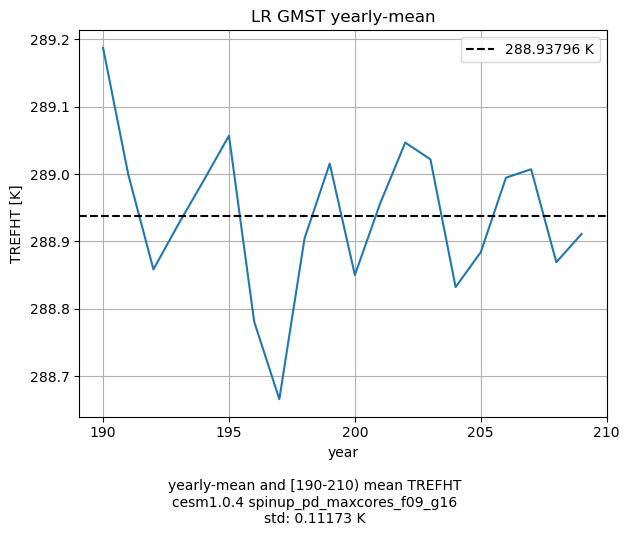

In [10]:
fig = plt.figure()
ax = fig.gca()
Tgm = dsya.TREFHT.isel(year=slice(0,-1)).weighted(dsya.gw).mean(('lat','lon'))
print(f"standard deviation: {Tgm.std('year'):.5} K")
Tgmtm = Tgm.mean('year')
Tgm.attrs.update({'units':'K'})
Tgm.plot(ax=ax)
ax.axhline(Tgmtm, linestyle='--', color='k', label=f"{Tgmtm.data:.5f} K")
plt.legend()
plt.xticks(range(190,211,5))
plt.grid()
plt.title('LR GMST yearly-mean')
fig.text(0.5, -0.1, 'yearly-mean and [190-210) mean TREFHT\ncesm1.0.4 spinup_pd_maxcores_f09_g16'
         +f'\nstd: {Tgm.std("year"):.5} K', ha='center')
plt.tight_layout()
fig.savefig("../plot/LR_GMST_YRLYMEAN.pdf", dpi=200)

### 0.5 degree resolution

In [40]:
files = glob.glob(os.path.join(P5+"/spinup_pd_maxcores_f05_t12.cam2.h0.????-??.nc"))
files_mr_190_210 = sorted([f for f in files if int(f[-9:-6]) in range(190,210)])
print(f"Found {len(files_mr_190_210)} files in {P5}")
print(f"First file:\t{os.path.basename(files_mr_190_210[0])}")
print(f"Last file:\t{os.path.basename(files_mr_190_210[-1])}")

Found 240 files in /projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/output/atm/hist
First file:	spinup_pd_maxcores_f05_t12.cam2.h0.0190-01.nc
Last file:	spinup_pd_maxcores_f05_t12.cam2.h0.0209-12.nc


In [42]:
%%time 
ds = read_netcdfs(files_mr_190_210, dim='time', data_vars=['TREFHT','time_bnds','gw'])

CPU times: user 18.4 s, sys: 1.35 s, total: 19.8 s
Wall time: 60 s


In [43]:
def weighted_tmean(ds): 
    td = ds.time_bnds.diff('nbnd').squeeze('nbnd').astype('float')
    return ds.weighted(td).mean('time')
  
ds = ds.assign_coords({'time_bnds':ds.time_bnds})
grps = ds.groupby(ds.time.dt.year)
dsya = grps.apply(weighted_tmean)

standard deviation: 0.086247 K


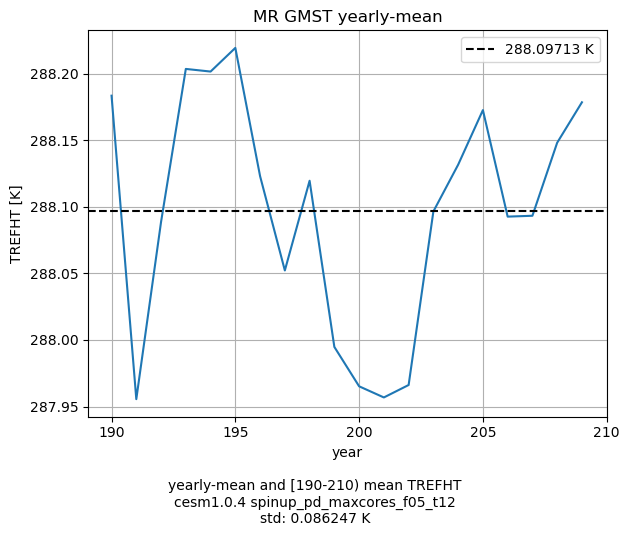

In [47]:
fig = plt.figure()
ax = fig.gca()
Tgm = dsya.TREFHT.isel(year=slice(0,-1)).weighted(dsya.gw).mean(('lat','lon'))
print(f"standard deviation: {Tgm.std('year'):.5} K")
Tgmtm = Tgm.mean('year')
Tgm.attrs.update({'units':'K'})
Tgm.plot(ax=ax)
ax.axhline(Tgmtm, linestyle='--', color='k', label=f"{Tgmtm.data:.5f} K")
plt.legend()
plt.xticks(range(190,211,5))
plt.grid()
plt.title('MR GMST yearly-mean')
fig.text(0.5, -0.1, 'yearly-mean and [190-210) mean TREFHT\ncesm1.0.4 spinup_pd_maxcores_f05_t12'
         +f'\nstd: {Tgm.std("year"):.5} K', ha='center')
plt.tight_layout()
fig.savefig("../plot/MR_GMST_YRLYMEAN.pdf", dpi=200)